In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from datetime import datetime
from tqdm import tqdm

In [2]:
ohlcv_cols = ['open', 'high', 'low', 'close', 'volume']
BTCUSDT15m = pd.read_parquet(r"C:\Users\USER\Documents\Tradingstuff\rawdatabinanceBTCUSDT-15m-data.parquet",columns=ohlcv_cols)
BTCUSDT = BTCUSDT15m.resample('1h').agg({'open':'first', 'high':'max', 'low':'min', 'close':'last', 'volume':'sum'})
BTCUSDT.head()

,open,high,low,close,volume
timestamp,,,,,
2023-01-01 00:00:00,16537.5,16540.9,16504.0,16527.0,5381.399
2023-01-01 01:00:00,16527.1,16554.3,16524.1,16550.4,3210.826
2023-01-01 02:00:00,16550.5,16557.1,16534.8,16542.4,2399.668
2023-01-01 03:00:00,16542.5,16542.5,16515.0,16529.3,3214.480
2023-01-01 04:00:00,16529.2,16530.4,16508.8,16517.8,3150.954


Lag with largest negative spike: 22, Slope: -0.0280


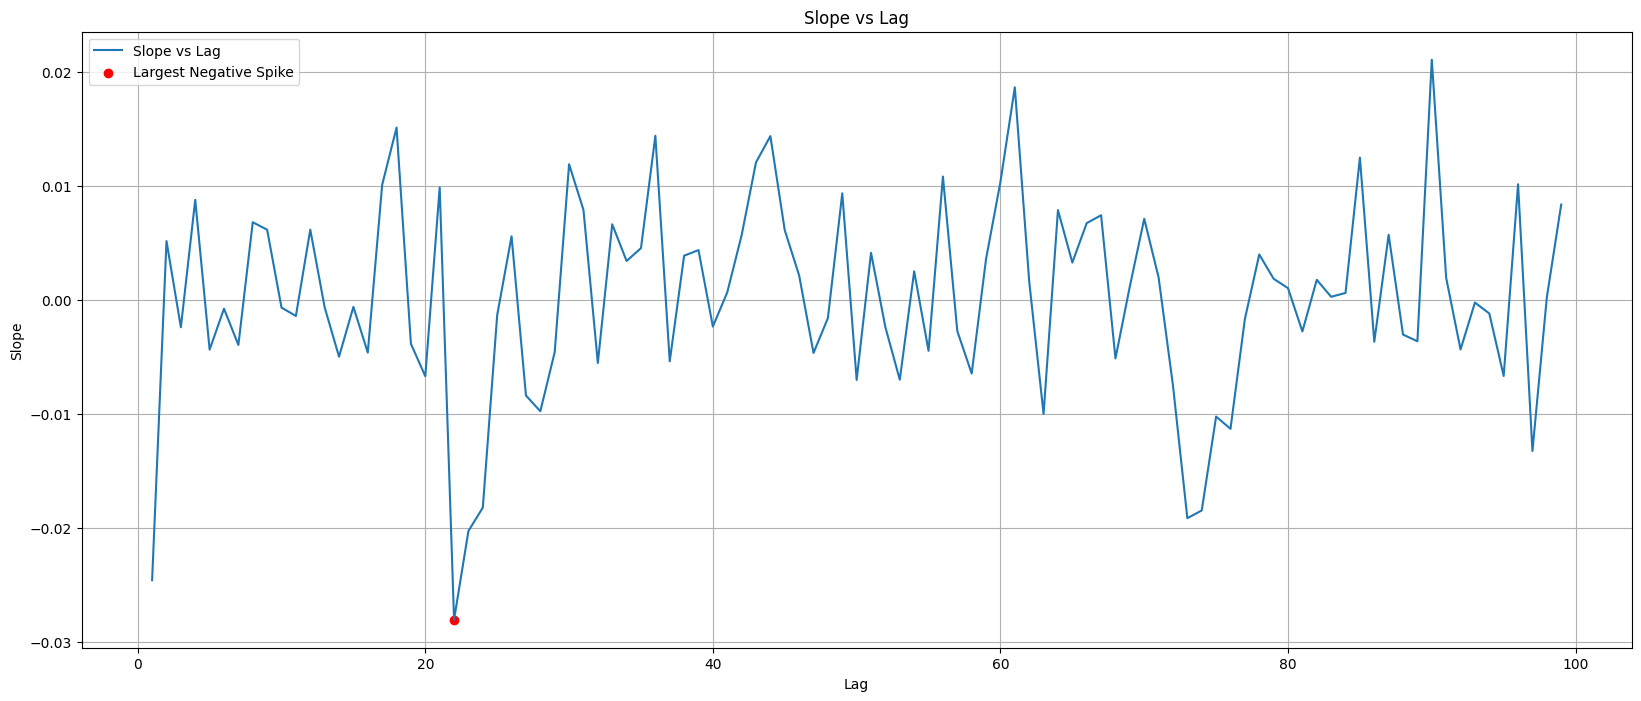

In [3]:
rets = np.array((BTCUSDT["close"] - BTCUSDT["open"]) / BTCUSDT["open"])
slopes = []
for lag in np.arange(1, 100):
    slope, intercept = np.polyfit(rets[:-lag], rets[lag:], 1)

    slopes.append(slope)

min_idx = np.argmin(slopes)
print(f"Lag with largest negative spike: {min_idx+1}, Slope: {slopes[min_idx]:.4f}")

plt.figure(figsize=(20,8))
plt.plot(np.arange(1, 100, 1), slopes, label='Slope vs Lag')
plt.scatter(min_idx+1, slopes[min_idx], color='red', label='Largest Negative Spike')
plt.xlabel('Lag')
plt.ylabel('Slope')
plt.title('Slope vs Lag')
plt.legend()
plt.grid()
plt.show()


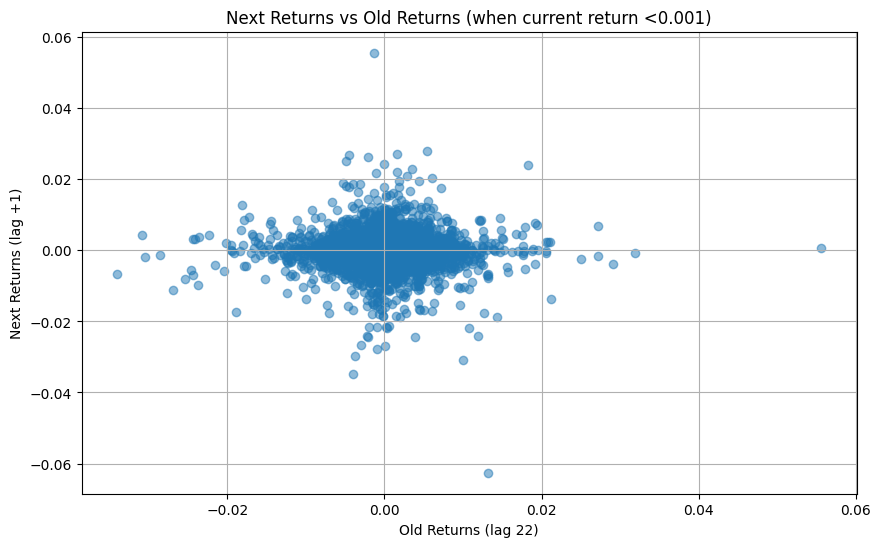

Slope: -0.01379, Intercept: 0.00002, R: -0.014, p-value: 0.249


In [4]:
old_rets = []
next_rets = []

for i in range(22, len(rets)-1):
    if abs(rets[i]) < 0.001:
        old_rets.append(rets[i-22])
        next_rets.append(rets[i+1])

# Plot next_rets against old_rets
plt.figure(figsize=(10,6))
plt.scatter(old_rets, next_rets, alpha=0.5)
plt.xlabel('Old Returns (lag 22)')
plt.ylabel('Next Returns (lag +1)')
plt.title('Next Returns vs Old Returns (when current return <0.001)')
plt.grid()
plt.show()

# Find the slope (linear regression)
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(old_rets, next_rets)
print(f"Slope: {slope:.5f}, Intercept: {intercept:.5f}, R: {r_value:.3f}, p-value: {p_value:.3g}")

C:\Users\USER\AppData\Local\Temp\ipykernel_24720\2318208888.py:9: RuntimeWarning: Mean of empty slice
  means.append(np.nanmean(temp))
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


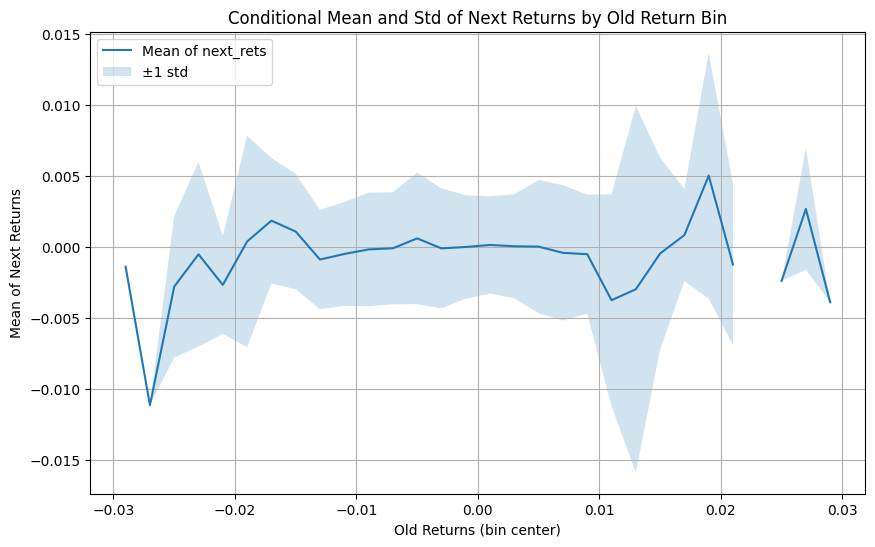

In [5]:
old_rets = np.array(old_rets)
next_rets = np.array(next_rets)

means = []
stds = []
bins = np.arange(-0.03, 0.03, 0.002)
for cur_ret in bins:
    temp = next_rets[(old_rets >= cur_ret) & (old_rets <= cur_ret + 0.002)]
    means.append(np.nanmean(temp))
    stds.append(np.nanstd(temp))

plt.figure(figsize=(10,6))
plt.plot(bins + 0.001, means, label='Mean of next_rets')
plt.fill_between(bins + 0.001, np.array(means)-np.array(stds), np.array(means)+np.array(stds), alpha=0.2, label='±1 std')
plt.xlabel('Old Returns (bin center)')
plt.ylabel('Mean of Next Returns')
plt.title('Conditional Mean and Std of Next Returns by Old Return Bin')
plt.grid()
plt.legend()
plt.show()

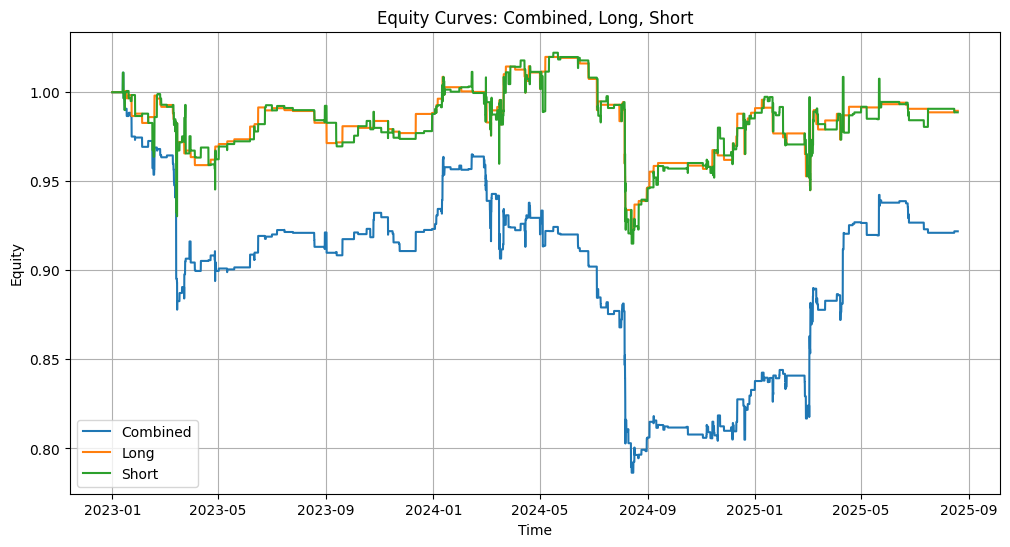

In [6]:
equity_combined = [1]
equity_long = [1]
equity_short = [1]
fees = 0.0005
for i in range(len(BTCUSDT)-1):
    if rets[i-22] < -0.016 and abs(rets[i-1]) < 0.01:
        equity_combined.append(equity_combined[i] + rets[i] - fees)
        equity_long.append(equity_long[i] + rets[i] - fees)
        equity_short.append(equity_long[i])
    elif rets[i-22] > 0.016 and abs(rets[i-1]) < 0.01:
        equity_combined.append(equity_combined[i] - rets[i] - fees)
        equity_long.append(equity_long[i])
        equity_short.append(equity_short[i] - rets[i] - fees)
    else:
        equity_combined.append(equity_combined[i])
        equity_long.append(equity_long[i])
        equity_short.append(equity_short[i])

# Plot the three equity curves with proper time axis
time_index = BTCUSDT.index[1:len(equity_combined)+1] if len(BTCUSDT.index) > len(equity_combined) else BTCUSDT.index[:len(equity_combined)]
plt.figure(figsize=(12,6))
plt.plot(time_index, equity_combined, label='Combined')
plt.plot(time_index, equity_long, label='Long')
plt.plot(time_index, equity_short, label='Short')
plt.xlabel('Time')
plt.ylabel('Equity')
plt.title('Equity Curves: Combined, Long, Short')
plt.legend()
plt.grid()
plt.show()